Regression Analysis

In [12]:
from pyspark.sql import SparkSession

# Start a Spark session
spark = SparkSession.builder.appName("JobPostingsAnalysis").getOrCreate()

# Load the CSV file into a Spark DataFrame
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./lightcast_job_postings.csv")

# Register the DataFrame as a temporary SQL view
df.createOrReplaceTempView("job_postings")

#df.show(5)

Data Preparation & Cleaning

In [13]:
# Cleaning REMOTE_TYPE_NAME column
# Missing values are replaced

from pyspark.sql.functions import when, col, trim

df = df.withColumn(
    "REMOTE_TYPE",
    when(col("REMOTE_TYPE") == 3, "Hybrid")
    .when(col("REMOTE_TYPE") == 1, "Remote")
    .when(col("REMOTE_TYPE") == 2, "Onsite")
    .otherwise("Onsite")
)

df = df.withColumn(
    "MIN_EDULEVELS",
    when(col("MIN_EDULEVELS") == 99, "Associate or lower")
    .when(col("MIN_EDULEVELS") == 0, "Associate or lower")
    .when(col("MIN_EDULEVELS") == 1, "Associate or lower")
    .when(col("MIN_EDULEVELS") == 2, "Bachelor")
    .when(col("MIN_EDULEVELS") == 3, "Master's")
    .when(col("MIN_EDULEVELS") == 4, "PhD")
    .otherwise("Associate or lower")
)

df = df.withColumn(
    "CITY_NAME",
    when((col("CITY_NAME").isNull()),"No City")
    .otherwise(col("CITY_NAME"))
)

df = df.withColumn(
    "STATE_NAME",
    when((col("STATE_NAME").isNull()),"No City")
    .otherwise(col("STATE_NAME"))
)

In [14]:
# Ensure numeric columns are of float type

df = df.withColumn("SALARY", col("SALARY").cast("float")) \
    .withColumn("SALARY_FROM", col("SALARY_FROM").cast("float")) \
    .withColumn("SALARY_TO", col("SALARY_TO").cast("float")) \
    .withColumn("MIN_YEARS_EXPERIENCE", col("MIN_YEARS_EXPERIENCE").cast("float")) \
    .withColumn("MAX_YEARS_EXPERIENCE", col("MAX_YEARS_EXPERIENCE").cast("float"))

In [15]:
# Removing any remaining NA values and selecting relevant columns for random forest analysis

from pyspark.sql.functions import col, pow
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Drop the NA values in relevant columns
rf_df = df.dropna(subset=[
    "MIN_YEARS_EXPERIENCE",
    "SALARY", 
    "REMOTE_TYPE",
    "STATE_NAME",
    "MIN_EDULEVELS",
    "NAICS2_NAME",
]).select(
    "MIN_YEARS_EXPERIENCE",
    "SALARY", 
    "REMOTE_TYPE",
    "STATE_NAME",
    "MIN_EDULEVELS",
    "NAICS2_NAME",
)

**Why select these variables?**

The goal of using these variables is to be able to identify how much wieght/impact locations (such as state) has on the salary, in comparison to other variables such as years of experience.

**Random Forest Model Deployment**

In [16]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

# Use only categoricals
categorical_columns = ["REMOTE_TYPE", "STATE_NAME", "MIN_EDULEVELS", "NAICS2_NAME"]

# Index -> OHE -> Assemble
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
            for c in categorical_columns]
encoders = [OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_ohe")
            for c in categorical_columns]
assembler = VectorAssembler(inputCols=[f"{c}_ohe" for c in categorical_columns],
                            outputCol="features")

# Model
rf = RandomForestRegressor(featuresCol="features", labelCol="SALARY",
                           numTrees=300, maxDepth=12, seed=42)

pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])

In [17]:
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="SALARY",
    numTrees=300,
    maxDepth=12,
    seed=42
)

pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])

#Train / Test Split - Using 80% of data for training and 20% for testing
train_df, test_df = rf_df.randomSplit([0.8, 0.2], seed=42)

# Fit and Predict
model = pipeline.fit(train_df)
pred = model.transform(test_df)

# RMSE, MAE, R squared
for metric in ["rmse", "mae", "r2"]:
    ev = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName=metric)
    print(metric.upper(), "=", ev.evaluate(pred))

25/10/10 18:33:42 WARN DAGScheduler: Broadcasting large task binary with size 1118.7 KiB
25/10/10 18:33:47 WARN DAGScheduler: Broadcasting large task binary with size 2009.6 KiB
25/10/10 18:33:52 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
25/10/10 18:34:00 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
25/10/10 18:34:09 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/10/10 18:34:19 WARN DAGScheduler: Broadcasting large task binary with size 1026.2 KiB
25/10/10 18:34:21 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
25/10/10 18:34:33 WARN DAGScheduler: Broadcasting large task binary with size 1203.7 KiB
25/10/10 18:34:35 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
25/10/10 18:34:47 WARN DAGScheduler: Broadcasting large task binary with size 1389.0 KiB
25/10/10 18:34:50 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB
25/10/10 18:35:02 WARN DAGScheduler: 

RMSE = 38837.40532573633


MAE = 30066.577004432453


R2 = 0.19334552245056114


*Interpretation*

These variables collectively explain the salary by about 20%.
Whereas in the testing data, the tested salaries were off by ~39K compared to the actuals.

**Feature Importance**

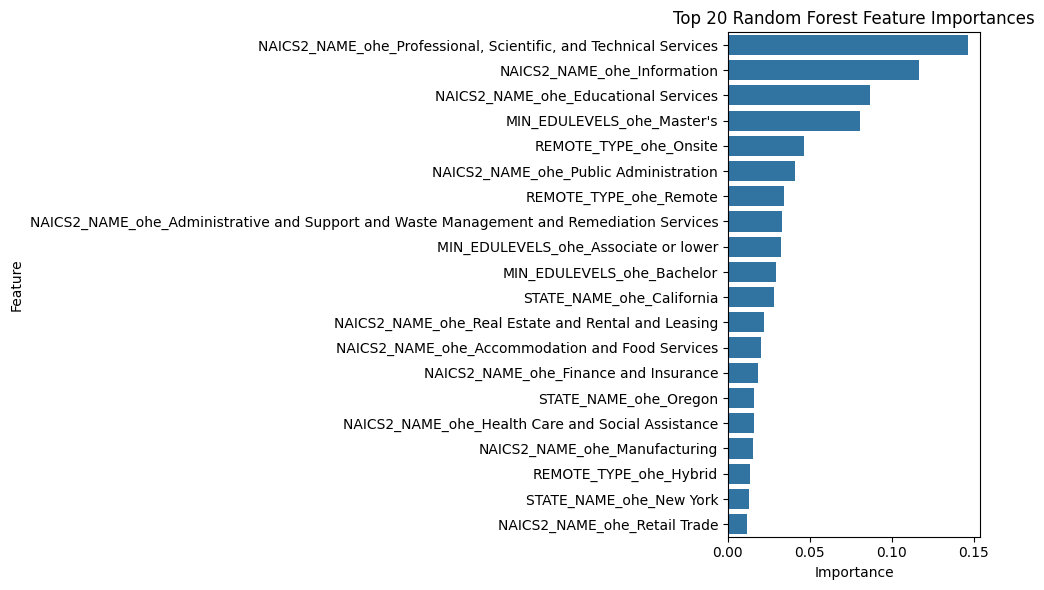

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rf_stage = model.stages[-1]
importances = np.array(rf_stage.featureImportances.toArray())

meta = pred.schema["features"].metadata["ml_attr"]["attrs"]
attrs = sorted([*meta.get("binary", []), *meta.get("numeric", [])], key=lambda a: a["idx"])
feature_names = [a["name"] for a in attrs]

topn = 20
feat_imp = (pd.DataFrame({"Feature": feature_names, "Importance": importances})
              .sort_values("Importance", ascending=False)
              .head(topn))

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp, x="Importance", y="Feature")
plt.title(f"Top {topn} Random Forest Feature Importances")
plt.xlabel("Importance"); plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Despite a relatively lower R squared value below 20% - this chart clearly shows that state (and ultimately location) has less influence on the amount of salary an employee receives compared to their education, position, and field. These three factors can be summarized as the amount of skill an employee has, and how much demand is required for said skill.

**Predictive Analysis (Extra Credit)**

This analysis uses test/fake data to estimate what the Random Forest model would predict the salaries to be.
There are 10 different variations of job type, state, education, etc. to predict each salary.

In [19]:
from pyspark.sql import functions as F

cat_cols = ["REMOTE_TYPE", "STATE_NAME", "MIN_EDULEVELS", "NAICS2_NAME"]
num_cols = ["MIN_YEARS_EXPERIENCE"]

# Generic data to test predictive analysis
test_data = [
    {"REMOTE_TYPE": "Onsite", "STATE_NAME": "California", "MIN_EDULEVELS": "Master's",
     "NAICS2_NAME": "Information", "MIN_YEARS_EXPERIENCE": 7.0},

    {"REMOTE_TYPE": "Remote", "STATE_NAME": "Texas", "MIN_EDULEVELS": "Associate or lower",
     "NAICS2_NAME": "Administrative and Support and Waste Management and Remediation Services", "MIN_YEARS_EXPERIENCE": 2.0},

    {"REMOTE_TYPE": "Onsite", "STATE_NAME": "Washington", "MIN_EDULEVELS": "Bachelor",
     "NAICS2_NAME": "Professional, Scientific, and Technical Services", "MIN_YEARS_EXPERIENCE": 12.0},

    {"REMOTE_TYPE": "Hybrid", "STATE_NAME": "Illinois", "MIN_EDULEVELS": "Bachelor",
     "NAICS2_NAME": "Finance and Insurance", "MIN_YEARS_EXPERIENCE": 6.0},

    {"REMOTE_TYPE": "Onsite", "STATE_NAME": "New York", "MIN_EDULEVELS": "Master's",
     "NAICS2_NAME": "Educational Services", "MIN_YEARS_EXPERIENCE": 10.0},

    {"REMOTE_TYPE": "Hybrid", "STATE_NAME": "Florida", "MIN_EDULEVELS": "Bachelor",
     "NAICS2_NAME": "Manufacturing", "MIN_YEARS_EXPERIENCE": 8.0},

    {"REMOTE_TYPE": "Onsite", "STATE_NAME": "Ohio", "MIN_EDULEVELS": "Associate or lower",
     "NAICS2_NAME": "Health Care and Social Assistance", "MIN_YEARS_EXPERIENCE": 3.0},

    {"REMOTE_TYPE": "Onsite", "STATE_NAME": "Virginia", "MIN_EDULEVELS": "PhD",
     "NAICS2_NAME": "Professional, Scientific, and Technical Services", "MIN_YEARS_EXPERIENCE": 9.0},

    {"REMOTE_TYPE": "Remote", "STATE_NAME": "Colorado", "MIN_EDULEVELS": "Bachelor",
     "NAICS2_NAME": "Real Estate and Rental and Leasing", "MIN_YEARS_EXPERIENCE": 7.0},

    {"REMOTE_TYPE": "Onsite", "STATE_NAME": "Michigan", "MIN_EDULEVELS": "Bachelor",
     "NAICS2_NAME": "Wholesale Trade", "MIN_YEARS_EXPERIENCE": 5.0},
]

new_df = spark.createDataFrame(test_data)

# Preventative for nulls in categoricals your pipeline indexes
new_df = new_df.fillna({c: "Unknown" for c in cat_cols})

# Predicting the salaries using trained pipeline model
pred = model.transform(new_df)

pred.select(*cat_cols, *num_cols, F.col("prediction").alias("predicted_salary")).show(truncate=False)

+-----------+----------+------------------+------------------------------------------------------------------------+--------------------+------------------+
|REMOTE_TYPE|STATE_NAME|MIN_EDULEVELS     |NAICS2_NAME                                                             |MIN_YEARS_EXPERIENCE|predicted_salary  |
+-----------+----------+------------------+------------------------------------------------------------------------+--------------------+------------------+
|Onsite     |California|Master's          |Information                                                             |7.0                 |170894.85297213428|
|Remote     |Texas     |Associate or lower|Administrative and Support and Waste Management and Remediation Services|2.0                 |114544.86580019069|
|Onsite     |Washington|Bachelor          |Professional, Scientific, and Technical Services                        |12.0                |140036.93253450037|
|Hybrid     |Illinois  |Bachelor          |Finance and Ins

The results are varied - in some instances the results align with our previous analysis - higher eduction, onsite, and tech should see higher salaries. For example, the first line and eigth line do have the highest salaries being in information and tech alongside 5+ years of experience, onsite, and higher education completed. However, the fith line has the lowest salary, but does not necessarily align in an intuitive sense - 10 years of experience, Masters, onsite, etc. should be ranked higher.

While the predictive power does show, fine tuning and additional model improvements can be made to improve the predictive capabilities.

**Clustering Analysis**

This clustering analysis explores salary and years of experience by the NAICS Name

[Silhouette] k=3  score=0.575



[Cluster → top labels]
Cluster 0: Professional, Scientific, and Technical Services:2722, Unclassified Industry:710, Finance and Insurance:702, Information:514, Administrative and Support and Waste Management and Remediation Services:462
Cluster 1: Professional, Scientific, and Technical Services:1212, Administrative and Support and Waste Management and Remediation Services:1073, Unclassified Industry:880, Finance and Insurance:826, Educational Services:563
Cluster 2: Professional, Scientific, and Technical Services:3270, Finance and Insurance:1577, Administrative and Support and Waste Management and Remediation Services:1093, Information:1019, Unclassified Industry:850


+-------+-----+------------------+------------------+
|cluster|    n|        avg_salary| avg_min_years_exp|
+-------+-----+------------------+------------------+
|      0| 6348|156468.69848771265|10.139729048519218|
|      1| 6997| 74872.70701729313|2.8339288266399887|
|      2|10352| 133393.5200927357|  4.50396058732612|
+-------+-----+------------------+------------------+



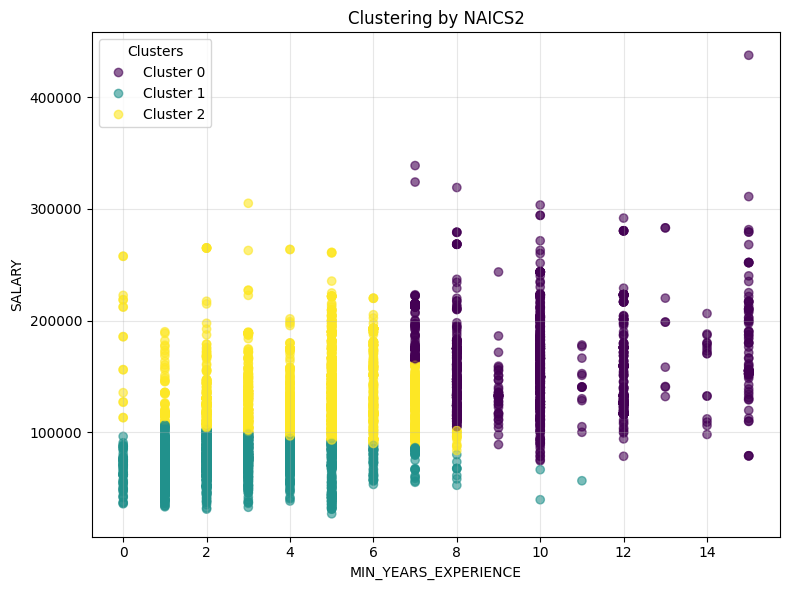

In [20]:
# KMEANS by NAICS NAME
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

label_col = "NAICS2_NAME"
numeric_features = ["SALARY", "MIN_YEARS_EXPERIENCE"]

# Prepare data
base = (
    rf_df.select(*(numeric_features + [label_col]))
         .withColumn("SALARY", F.col("SALARY").cast("double"))
         .withColumn("MIN_YEARS_EXPERIENCE", F.col("MIN_YEARS_EXPERIENCE").cast("double"))
         .na.drop(subset=numeric_features + [label_col])
)

# Using the log of salary to reduce skew and defining features before using them
base = base.withColumn("log_salary", F.log1p(F.col("SALARY")))
features_for_model = ["log_salary", "MIN_YEARS_EXPERIENCE"]

assembler = VectorAssembler(inputCols=features_for_model, outputCol="features_raw")
scaler    = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)

# Finding the best k by silhouette method
label_count = base.select(label_col).distinct().count()
k_candidates = sorted({2,3,4,5,6,7,8, label_count})

evalr = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette")
best_score, best_model = -1.0, None
for k in [k for k in k_candidates if k >= 3]:
    km   = KMeans(k=k, seed=42, featuresCol="features", predictionCol="prediction")
    pipe = Pipeline(stages=[assembler, scaler, km]).fit(base)
    score = evalr.evaluate(pipe.transform(base))
    if score > best_score:
        best_score, best_model = score, pipe

print(f"[Silhouette] k={best_model.stages[-1].getK()}  score={best_score:.3f}")

# Prediction
pred = best_model.transform(base).withColumnRenamed("prediction", "cluster")

pdf = pred.select("cluster", label_col, *features_for_model).toPandas()

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
import numpy as np, pandas as pd

y_c = pdf["cluster"].to_numpy()
y_l = pdf[label_col].astype(str).to_numpy()

ct = pd.crosstab(y_c, y_l)         # purity
purity = ct.max(axis=1).sum() / ct.values.sum()

print("\n[Cluster → top labels]")
for cl, row in ct.iterrows():
    top = row.sort_values(ascending=False).head(5)
    print(f"Cluster {cl}: " + ", ".join([f"{k}:{v}" for k,v in top.items()]))

# Summarized data per cluster   
pred.groupBy("cluster").agg(
    F.count("*").alias("n"),
    F.avg("SALARY").alias("avg_salary"),
    F.avg("MIN_YEARS_EXPERIENCE").alias("avg_min_years_exp")
).orderBy("cluster").show()

# Visualizing the results
plot_pdf = pred.select("MIN_YEARS_EXPERIENCE", "SALARY", "cluster") \
               .sample(False, 0.25, 42).toPandas()
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
s = plt.scatter(plot_pdf["MIN_YEARS_EXPERIENCE"], plot_pdf["SALARY"], c=plot_pdf["cluster"], alpha=.6)
plt.xlabel("MIN_YEARS_EXPERIENCE"); plt.ylabel("SALARY")
plt.title("Clustering by NAICS2")
handles,_ = s.legend_elements()
plt.legend(handles, [f"Cluster {i}" for i in sorted(plot_pdf['cluster'].unique())], title="Clusters")
plt.grid(True, alpha=.3); plt.tight_layout(); plt.show()


The KMeans cluster mostly uses salaries to seperate each cluster group - while some clusters pay lower or higher pay at the same years of experience, this suggests that the industry does influence salaries at different levels of experience. Overall, salaries generally rise with experience, though industry effects can override that pattern.

**Additional Analytics**

This section is to provide a quick salary state comparison

In [21]:
from pyspark.sql import functions as F

# Average salary by state
state_salary = (
    rf_df
      .select("STATE_NAME", "SALARY")
      .withColumn("SALARY", F.col("SALARY").cast("double"))
      .na.drop(subset=["STATE_NAME", "SALARY"])
      .groupBy("STATE_NAME")
      .agg(
          F.count("*").alias("n_postings"),
          F.avg("SALARY").alias("avg_salary"),
          F.expr("percentile_approx(SALARY, 0.5)").alias("median_salary")
      )
      .orderBy(F.col("avg_salary").desc())
)
state_salary.show(60, truncate=False)

# Pandas table
tbl = (
    state_salary
      .withColumn("avg_salary", F.round("avg_salary", 0))
      .withColumn("median_salary", F.round("median_salary", 0))
      .orderBy(F.col("avg_salary").desc())
      .toPandas()
)
print(tbl)

+---------------------------------------+----------+------------------+-------------+
|STATE_NAME                             |n_postings|avg_salary        |median_salary|
+---------------------------------------+----------+------------------+-------------+
|Connecticut                            |337       |132311.49554896142|128250.0     |
|Vermont                                |76        |130313.26315789473|121300.0     |
|New Jersey                             |639       |129825.1392801252 |127000.0     |
|California                             |2905      |129321.2464716007 |125900.0     |
|Delaware                               |131       |128099.2824427481 |124497.0     |
|Virginia                               |1039      |127059.95765158806|124900.0     |
|Washington                             |736       |127048.63451086957|122500.0     |
|Arkansas                               |255       |126950.65098039215|122195.0     |
|Massachusetts                          |591       |12

                                 STATE_NAME  n_postings  avg_salary  \
0                               Connecticut         337    132311.0   
1                                   Vermont          76    130313.0   
2                                New Jersey         639    129825.0   
3                                California        2905    129321.0   
4                                  Delaware         131    128099.0   
5                                  Virginia        1039    127060.0   
6                                Washington         736    127049.0   
7                                  Arkansas         255    126951.0   
8                             Massachusetts         591    125961.0   
9                                  Illinois         959    125789.0   
10                                 Nebraska         163    125679.0   
11  Washington, D.C. (District of Columbia)         390    124774.0   
12                                 Michigan         569    124122.0   
13    